# Import

In [1]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from numpy import linalg as LA
from tqdm import tqdm

# Read data

In [85]:
dim_num = 10
text_vectors = np.loadtxt(f"./data/vector/{dim_num}.csv", delimiter=',')

In [86]:
ag_news_df = pd.read_csv(
    "../data/CharCnn_Keras-master/data/ag_news_csv/train.csv",
    header=None,
    names=["class", "title", "description"],
)

# Functions

In [87]:
def centralize_array(array):
    return array - np.mean(array, axis=0)

In [88]:
def normarize_array(array):
    return array / np.sqrt(np.sum(array * array, axis=1).reshape(-1, 1))

In [89]:
def normarize_vector(vector):
    return vector / np.sqrt(np.sum(vector * vector))

In [90]:
def get_average_vector(vectors):
    sum_vector = np.sum(vectors, axis=0)
    return normarize_vector(sum_vector)

# preprocessing

In [91]:
centralized_vectors = centralize_array(text_vectors)

In [93]:
normarized_vectors = normarize_array(centralized_vectors)

# get similarity

## get average vector

In [95]:
classes = range(1, 5)

In [96]:
average_vectors = dict()
for average_class in classes:
    class_vectors = normarized_vectors[ag_news_df[ag_news_df["class"] == average_class].index]
    average_vectors[average_class] = get_average_vector(class_vectors)

## get cosin similarity of average vector

In [98]:
cosine_sim_df = pd.DataFrame()
for class_x, vector_x in average_vectors.items():
    cosine_sims = []
    for class_y, vector_y in average_vectors.items():
        cosine_sim = cosine_similarity(vector_x.reshape(1, -1), vector_y.reshape(1, -1))
        cosine_sims.append(cosine_sim)
    cosine_sim_df[class_x] = cosine_sims

## get cosine simirarity of average vector and vectors

In [99]:
cosine_sims_dicts = dict()
for average_class in tqdm(classes):
    average_vector = average_vectors[average_class]
    cosine_sims_dict = dict()
    for vector_class in classes:
        cosine_sims = list()
        for vector in normarized_vectors[ag_news_df[ag_news_df["class"] == vector_class].index]:
            cosine_sim = cosine_similarity(
                average_vector.reshape(1, -1), vector.reshape(1, -1)
            )
            cosine_sims.append(cosine_sim)
        cosine_sims_dict[vector_class] = cosine_sims
    cosine_sims_dicts[average_class] = cosine_sims_dict

100%|██████████| 4/4 [06:47<00:00, 101.85s/it]


## calc average similarity

In [100]:
average_sims = list()
for class_num_ave, cosine_sims_dict in cosine_sims_dicts.items():
    average_sim = list()
    for class_num_vec, cosine_sims in cosine_sims_dict.items():
        cosine_sims = np.stack(cosine_sims).reshape(-1)
        average_sim.append(np.average(np.arccos(cosine_sims)))
    average_sims.append(average_sim)
average_sims = pd.DataFrame(average_sims)

# show argument

## argument distribution

In [101]:
vecs = dict()
for classNum, vectors in cosine_sims_dict.items():
    vec = np.stack(vectors)
    vecs[classNum] = vec.reshape(-1)

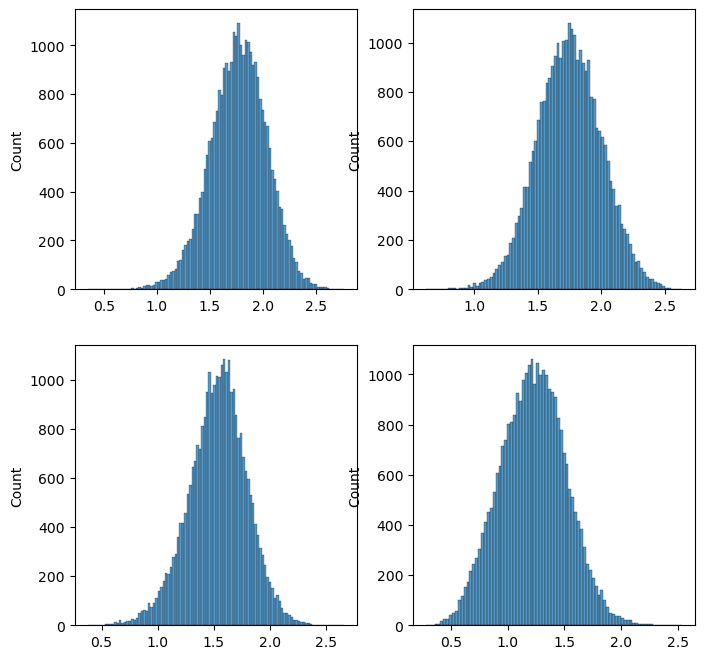

In [102]:
fig = plt.figure(figsize=(8, 8))
for classNum in range(1, 5):
    ax = fig.add_subplot(2, 2, classNum)
    sns.histplot(np.arccos(vecs[classNum]), ax=ax)

## show similarity matrix

In [103]:
average_sims / np.pi

,0,1,2,3
0,0.377502,0.538061,0.518705,0.558338
1,0.534022,0.362556,0.560140,0.545944
2,0.521869,0.580474,0.398864,0.487446
3,0.562953,0.556584,0.488297,0.389591


<AxesSubplot: >

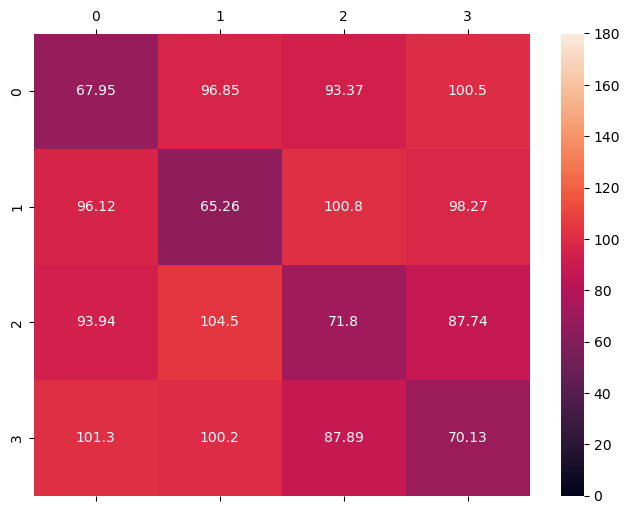

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.xaxis.tick_top()
ax.xaxis.set_ticks_position("both")

sns.heatmap(average_sims * 180/ np.pi, vmin=0, vmax=180, annot=True, fmt=".4g", ax=ax)

<AxesSubplot: >

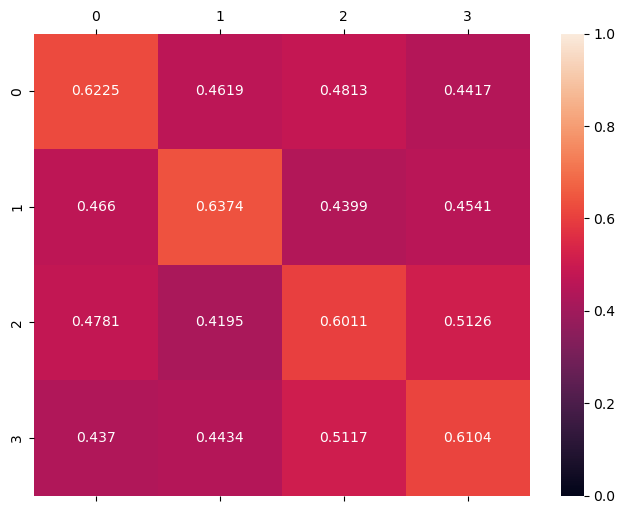

In [105]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.xaxis.tick_top()
ax.xaxis.set_ticks_position("both")

sns.heatmap(1 - average_sims / np.pi, vmin=0, vmax=1, annot=True, fmt=".4g", ax=ax)

# calc distance between identity matrix and similarity matrix

In [106]:
norm_dims = [1, 2, "fro", np.inf]
sim_matrix = 1 - average_sims / np.pi
for norm_dim in norm_dims:
    print(LA.norm(sim_matrix - np.identity(4), norm_dim))

1.831721679570563
1.0053747394962615
1.777215677483133
1.8090753211666917


In [19]:
norm_dims = [1, 2, "fro", np.inf]
sim_matrix = 1 - average_sims / np.pi
for norm_dim in norm_dims:
    print(LA.norm(sim_matrix - np.identity(4), norm_dim))

2.2731539145488213
1.8014894073471945
2.38246719403002
2.305811042097262
